# Import librerie

Import delle librerie e del dataset

In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import scipy.stats as stats 
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import rpy2

# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Progetto SDMTSA/data2022_train.csv"
data = pd.read_csv(path)

In [4]:
print(data.head())

            Unnamed: 0            y
0  2017-01-01 00:00:00  34055.69620
1  2017-01-01 00:10:00  29814.68354
2  2017-01-01 00:20:00  29128.10127
3  2017-01-01 00:30:00  28228.86076
4  2017-01-01 00:40:00  27335.69620


# Pre-processing

Cambio il nome alle colonne

In [5]:
data = data.rename(columns = {'Unnamed: 0':'Date', 'y':'Value'}, inplace = False)

In [6]:
print(data.head())

                  Date        Value
0  2017-01-01 00:00:00  34055.69620
1  2017-01-01 00:10:00  29814.68354
2  2017-01-01 00:20:00  29128.10127
3  2017-01-01 00:30:00  28228.86076
4  2017-01-01 00:40:00  27335.69620


## Valori nulli e/o duplicati

Vediamo se ci sono valori nulli e/o valori NA e/o valori duplicati.

In [7]:
print(data['Value'].isnull())

0        False
1        False
2        False
3        False
4        False
         ...  
48091    False
48092    False
48093    False
48094    False
48095    False
Name: Value, Length: 48096, dtype: bool


In [8]:
print(data.isnull().sum())

Date     0
Value    0
dtype: int64


In [9]:
print(sum(data.duplicated()))

0


In [10]:
data.isnull().values.any()

False

In [11]:
data.isna().any(axis=None)

False

Non ci sono missing values, né valori NA, né valori mancanti.

## Manipolazione della data e creazione di colonne aggiuntive

Trasformo la colonna Date in datetime

In [12]:
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
print(data.head())

                 Date        Value
0 2017-01-01 00:00:00  34055.69620
1 2017-01-01 00:10:00  29814.68354
2 2017-01-01 00:20:00  29128.10127
3 2017-01-01 00:30:00  28228.86076
4 2017-01-01 00:40:00  27335.69620


Faccio una divisione della data in: anno, giorno, mese, ora, minuti, secondi

In [14]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Day'] = data.Date.dt.day
data['Hour'] = data.Date.dt.hour
data['Minute'] = data.Date.dt.minute
data['Second'] = data.Date.dt.second
data['WeekDay'] = data.Date.dt.day_name()
data['Month_Name'] = data.Date.dt.strftime("%B")

data['Num_DayofYear'] = data['Date'].dt.dayofyear
data['Num_DayofWeek'] = data['Date'].dt.dayofweek
data['Num_WeekofYear'] = data['Date'].dt.isocalendar().week

data['Quarter'] = data['Date'].dt.quarter

data['Just_Date'] = data['Date'].dt.date

Set della data comoleta come index

In [15]:
data.set_index(data['Date'], inplace = True)

In [16]:
data = data.drop(['Date'], axis = 1)
data['Month_Name'] = data.index.strftime("%B")

In [17]:
print(data.head())

                           Value  Year  Month  Day  Hour  Minute  Second  \
Date                                                                       
2017-01-01 00:00:00  34055.69620  2017      1    1     0       0       0   
2017-01-01 00:10:00  29814.68354  2017      1    1     0      10       0   
2017-01-01 00:20:00  29128.10127  2017      1    1     0      20       0   
2017-01-01 00:30:00  28228.86076  2017      1    1     0      30       0   
2017-01-01 00:40:00  27335.69620  2017      1    1     0      40       0   

                    WeekDay Month_Name  Num_DayofYear  Num_DayofWeek  \
Date                                                                   
2017-01-01 00:00:00  Sunday    January              1              6   
2017-01-01 00:10:00  Sunday    January              1              6   
2017-01-01 00:20:00  Sunday    January              1              6   
2017-01-01 00:30:00  Sunday    January              1              6   
2017-01-01 00:40:00  Sunday    Janu

In [18]:
print(data)

                           Value  Year  Month  Day  Hour  Minute  Second  \
Date                                                                       
2017-01-01 00:00:00  34055.69620  2017      1    1     0       0       0   
2017-01-01 00:10:00  29814.68354  2017      1    1     0      10       0   
2017-01-01 00:20:00  29128.10127  2017      1    1     0      20       0   
2017-01-01 00:30:00  28228.86076  2017      1    1     0      30       0   
2017-01-01 00:40:00  27335.69620  2017      1    1     0      40       0   
...                          ...   ...    ...  ...   ...     ...     ...   
2017-11-30 23:10:00  31347.69231  2017     11   30    23      10       0   
2017-11-30 23:20:00  30603.07692  2017     11   30    23      20       0   
2017-11-30 23:30:00  29889.23077  2017     11   30    23      30       0   
2017-11-30 23:40:00  29249.23077  2017     11   30    23      40       0   
2017-11-30 23:50:00  28584.61538  2017     11   30    23      50       0   

           

# Analisi Esplorativa

## Rappresentazioni per granularità della serie

Serie storica vista nella sua totalità.

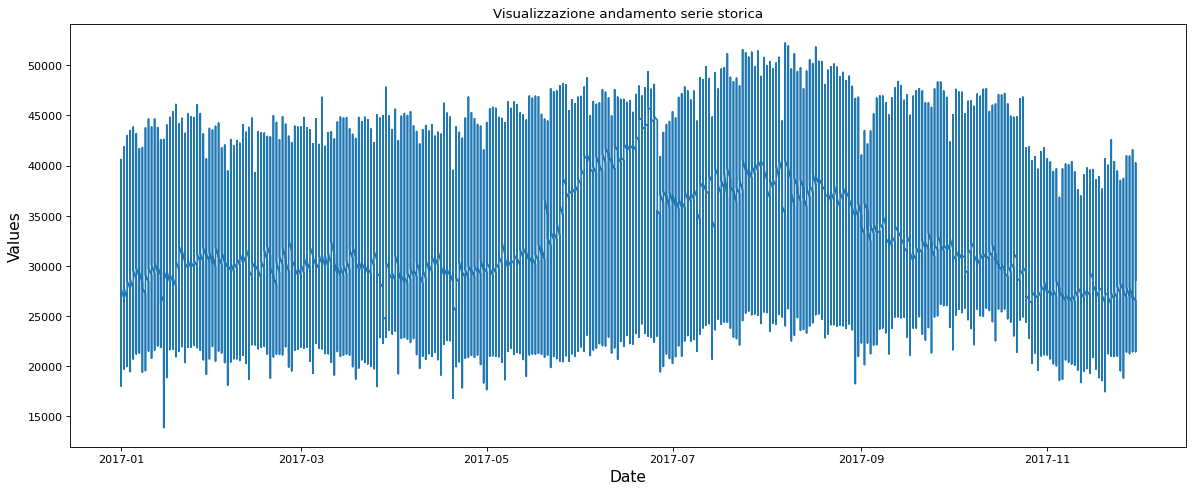

In [19]:
figure(figsize=(18, 7), dpi=80, linewidth=10)
plt.plot(data['Just_Date'], data['Value'])
plt.title('Visualizzazione andamento serie storica')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.show()

Serie storica vista nella sua totalità, ma con granularità GIORNALIERA.

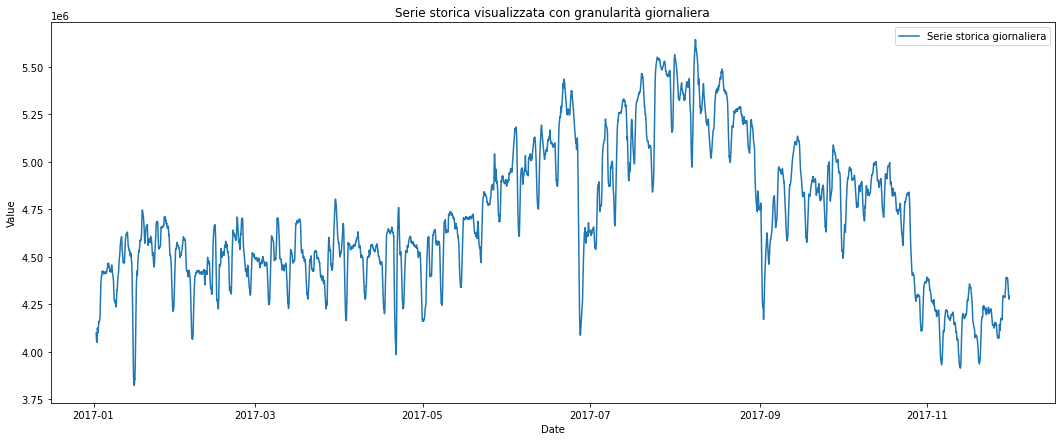

In [20]:
# Calcolo la media rolling giornaliera della serie storica
serie_giorn = data['Value'].rolling(window=144).sum() #144 è 24*6 quindi un giorno 
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_giorn, label="Serie storica giornaliera")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità giornaliera")
plt.legend()
plt.show()

Serie storica vista nella sua totalità, ma con granularità SETTIMANALE.

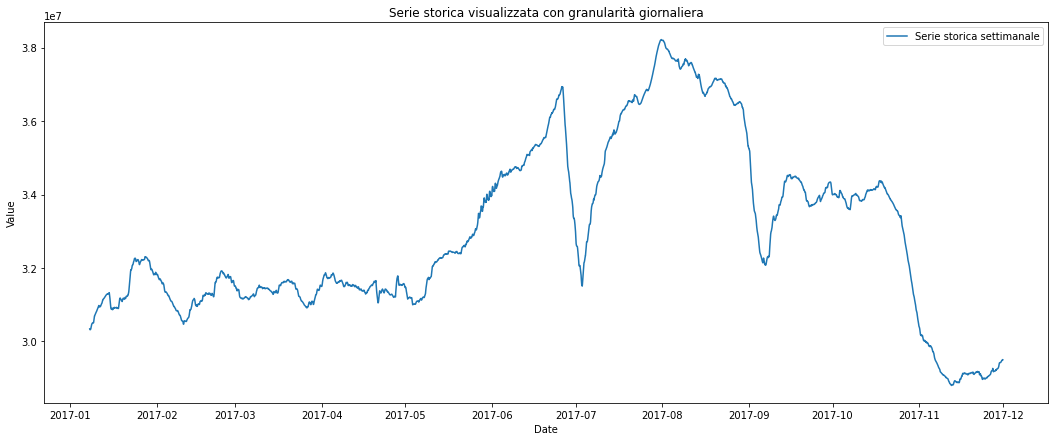

In [21]:
# Calcolo la media rolling giornaliera della serie storica
serie_sett = data['Value'].rolling(window=1008).sum() #1008 settimanale, 6*24*7
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_sett, label="Serie storica settimanale")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità giornaliera")
plt.legend()
plt.show()

Serie storica vista nella sua totalità, ma con granularità MENSILE.

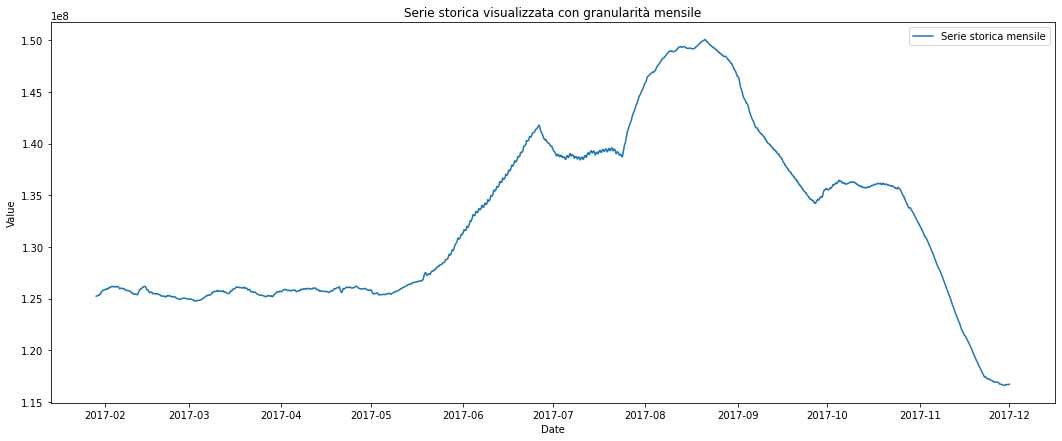

In [22]:
# Calcolo la media rolling giornaliera della serie storica
serie_mensile = data['Value'].rolling(window=4032).sum() # 4032 mensile, 6*24*7*4
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_mensile, label="Serie storica mensile")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità mensile")
plt.legend()
plt.show()

## Altre analisi

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


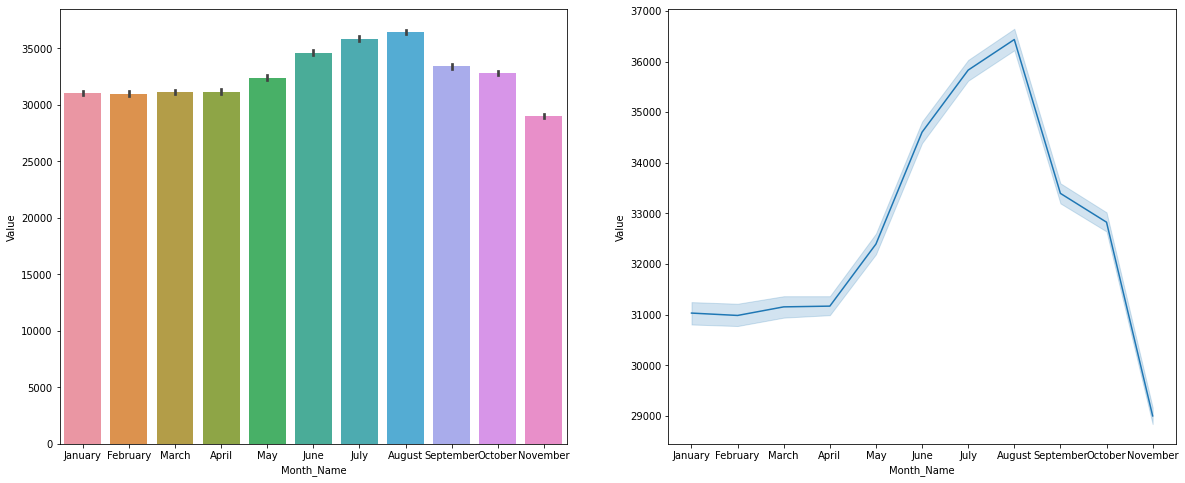

In [23]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Month_Name'], data['Value'], ax = ax[0])
sns.lineplot(data['Month_Name'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


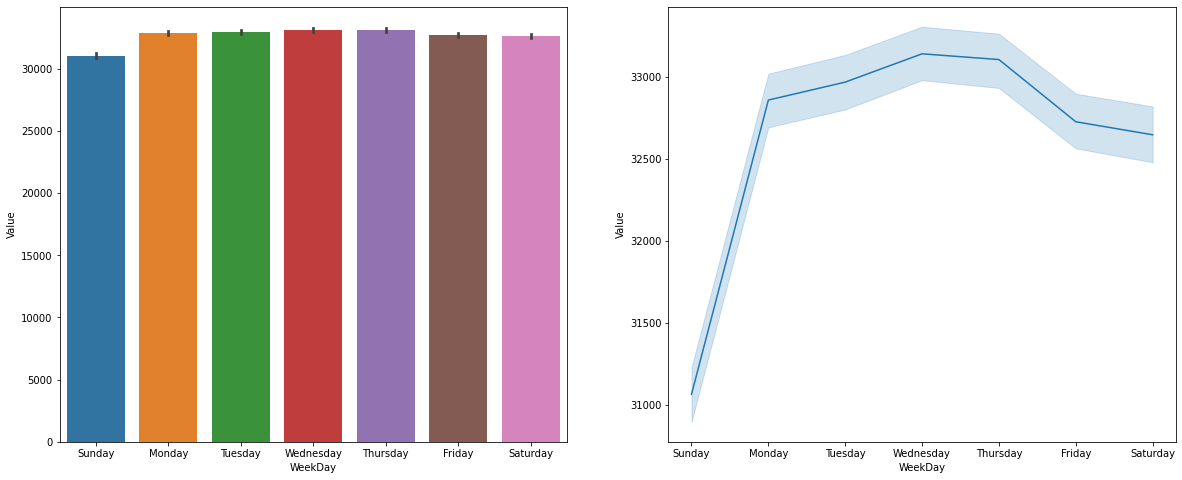

In [24]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['WeekDay'], data['Value'], ax = ax[0])
sns.lineplot(data['WeekDay'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


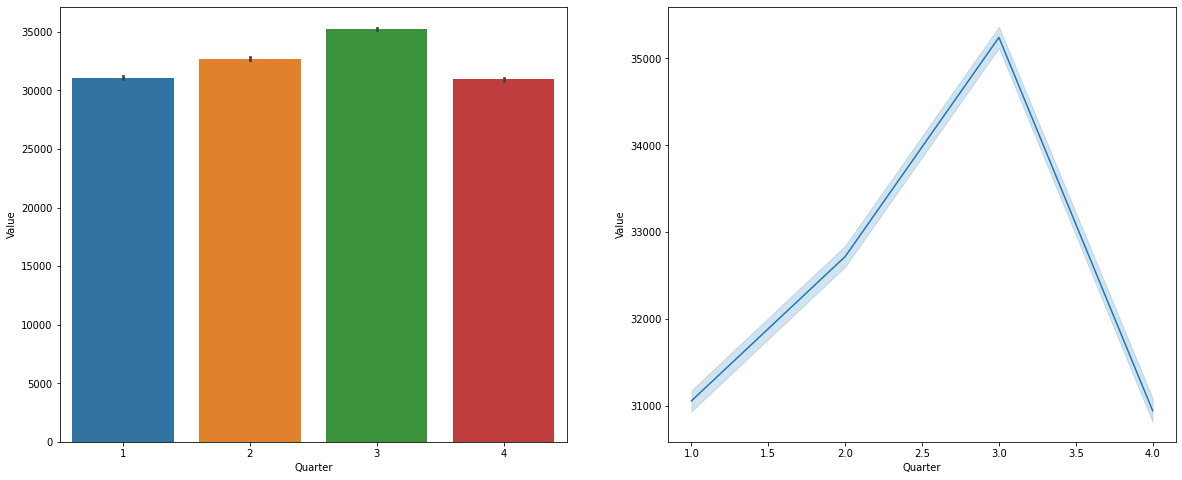

In [25]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Quarter'], data['Value'], ax = ax[0])
sns.lineplot(data['Quarter'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


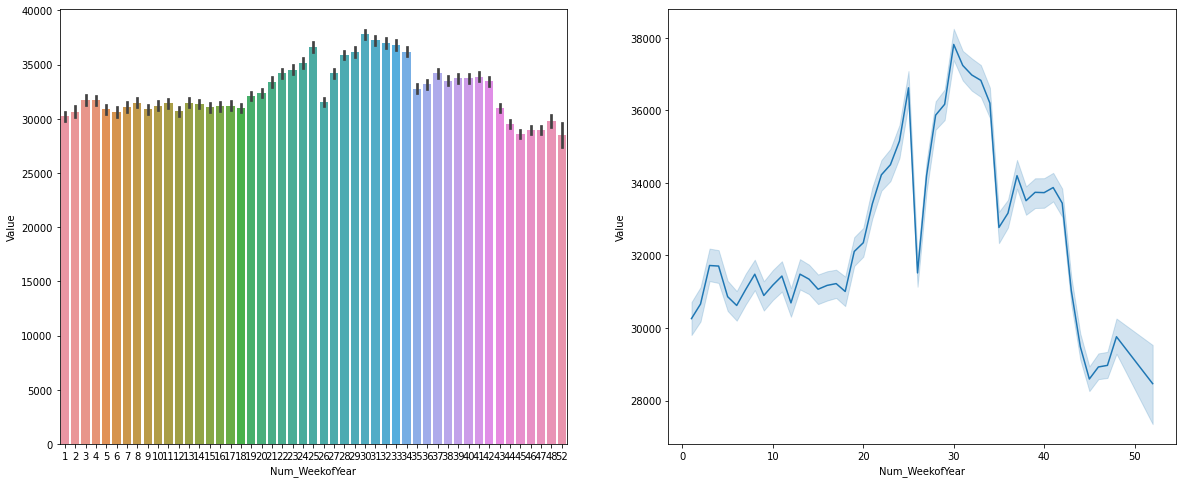

In [26]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Num_WeekofYear'], data['Value'], ax = ax[0])
sns.lineplot(data['Num_WeekofYear'], data['Value'], ax = ax[1])

### Andamento in funzione dell'ora del giorno

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


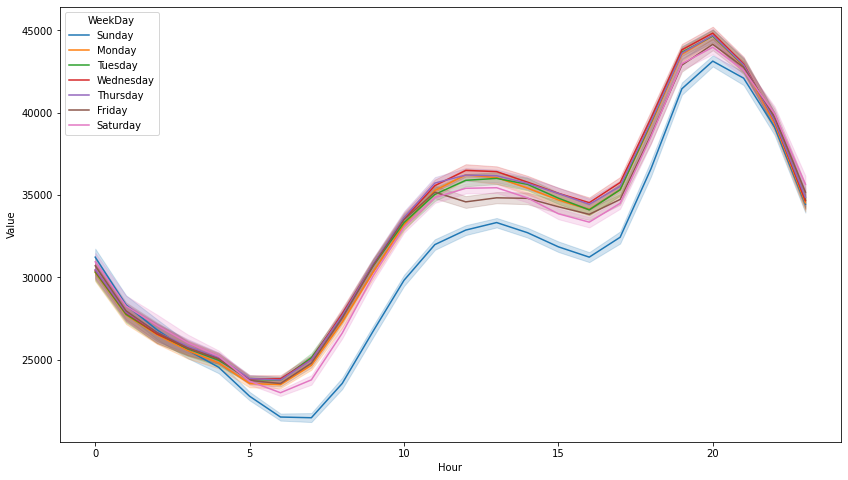

In [27]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['Hour'], data['Value'], hue = data['WeekDay'])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


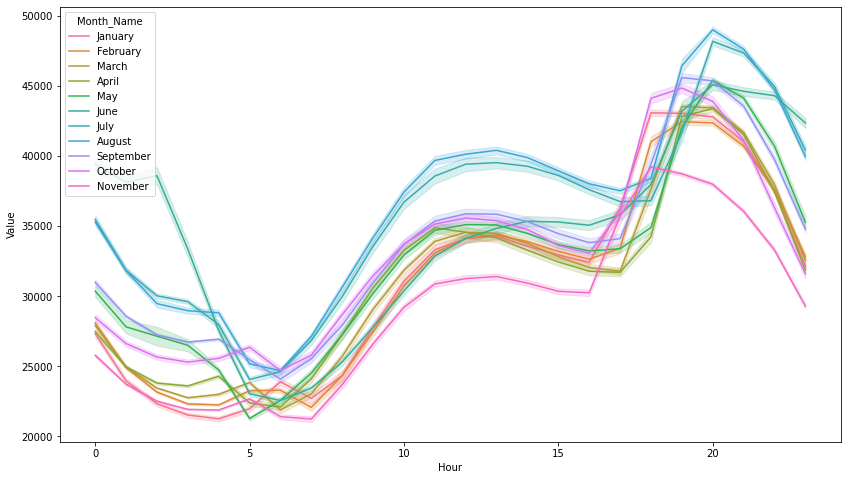

In [28]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['Hour'], data['Value'], hue = data['Month_Name'])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


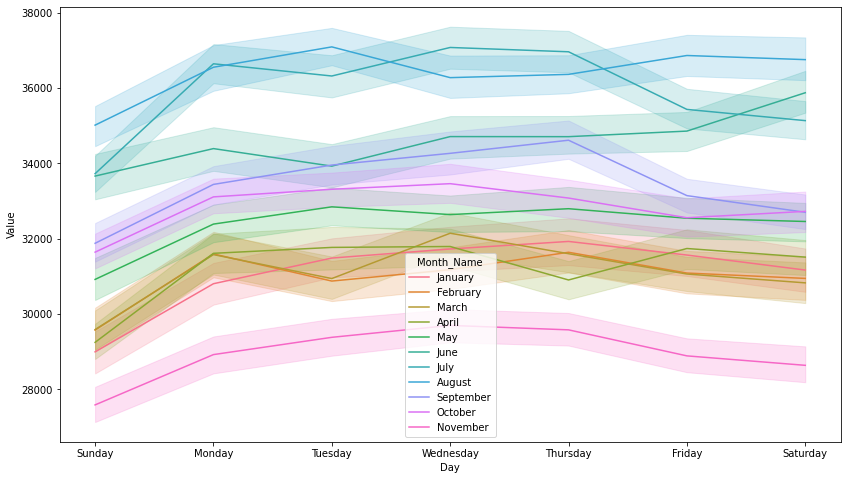

In [29]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['WeekDay'], data['Value'], hue = data['Month_Name'])
plt.xlabel('Day')
plt.ylabel('Value')
plt.show()

### Boxplot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

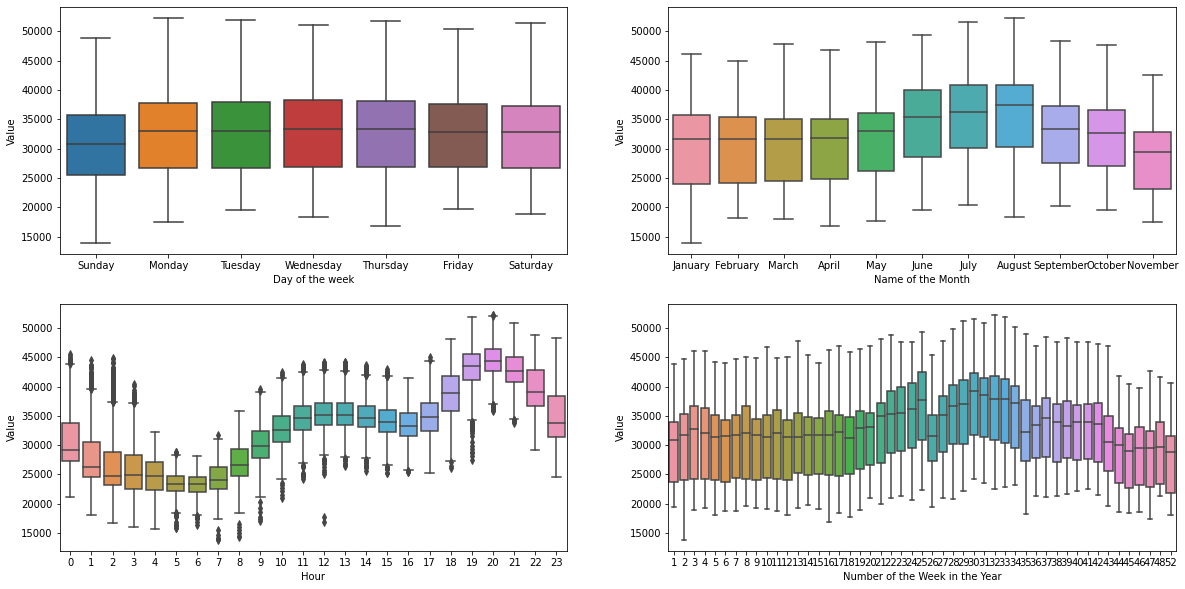

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.boxplot(data['WeekDay'], data['Value'], ax=ax[0][0]) #giorno della settimana
ax[0][0].set_xlabel('Day of the week')
ax[0][0].set_ylabel('Value')

sns.boxplot(data['Hour'], data['Value'], ax=ax[1][0]) #ora
ax[1][0].set_xlabel('Hour')
ax[1][0].set_ylabel('Value')

sns.boxplot(data['Month_Name'], data['Value'], ax=ax[0][1]) #mese
ax[0][1].set_xlabel('Name of the Month')
ax[0][1].set_ylabel('Value') 

sns.boxplot(data['Num_WeekofYear'], data['Value'], ax=ax[1][1]) #numero della settimana
ax[1][1].set_xlabel('Number of the Week in the Year')
ax[1][1].set_ylabel('Value')

plt.show()

Andamento all'interno della settimana abbastanza simile (si abbassa la domenica).
Giugno luglio e agosto in crescita, poi scende di nuovo a settembre, novembre valori più bassi. 
Durante il giorno le ore con consumi più bassi sono le 5,6,7, mentre quelle con consumi maggiori sono le 19 e le 20.
Settimana 26 segna discesa significativa, poi risale e torna a scendere alla 42 (con 44 picco negativo).

# Analisi Serie Storica

## Divisione train validation

Divido in train set e validation set.

In [31]:
train_set = data.loc[ : "2017-10-31 23:50:00"]
validation_set = data.loc["2017-11-01 00:00:00" : ]

In [32]:
validation_set

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30


## Definizione funzioni per calcolo ADF e KPSS

In [33]:
# ADF Test
def run_adf_test(x):
    result_ADF = adfuller(x.values, autolag='AIC')
    print(f'ADF Statistic: {result_ADF[0]}')
    print(f'p-value: {result_ADF[1]}')
    for key, value in result_ADF[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_ADF[1] < 0.05:
        print("The time series is stationary in mean.")
    else:
        print("The time series is not stationary in mean.")

In [34]:
# KPSS Test
def run_kpss_test(x):
    result_KPSS = kpss(x.values, regression='c')
    print('\nKPSS Statistic: %f' % result_KPSS[0])
    print('p-value: %f' % result_KPSS[1])
    for key, value in result_KPSS[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_KPSS[1] < 0.05:
        print("The time series is not stationary in variance.")
    else:
        print("The time series is stationary in variance.")

### Calcolo valori dei test sulla serie storica

#### ADF

Controllo stazionarietà in media con ADF.

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
https://www.machinelearningplus.com/time-series/time-series-analysis-python/ punto 10

In [35]:
resultADF = run_adf_test(data['Value'])

ADF Statistic: -33.537036738955436
p-value: 0.0
Critical Values:
   1%, -3.4304861235884645
Critical Values:
   5%, -2.8616001637764574
Critical Values:
   10%, -2.56680202319782
The time series is stationary in mean.


AD dice che la serie storica è stazionaria in media, rigetto l'ipotesi nulla di non stazionarietà (p-value inferiore a 0.05). Stazionaria in media.

Plot della media della serie storica.

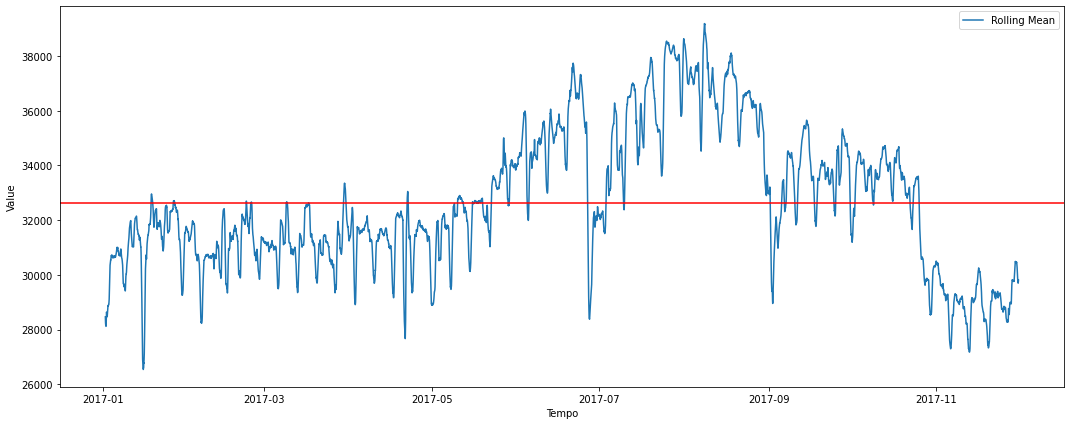

In [36]:
# Calcolo la media rolling giornaliera della serie storica
rolling_mean = data['Value'].rolling(window=144).mean() #144 è 24*6 quindi un giorno 
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_mean, label="Rolling Mean")
plt.axhline(data['Value'].mean(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

#### KPSS

Controllo stazionarietà in varianza con KPSS.

In [37]:
resultKPSS = run_kpss_test(data['Value'])


KPSS Statistic: 4.157840
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Rigetto l'ipotesi nulla di stazionarietà in varianza, KPSS mi dice che la serie storica non è stazionaria in varianza.
La serie storica non è stazionaria in varianza.

Plot della varianza della serie storica.

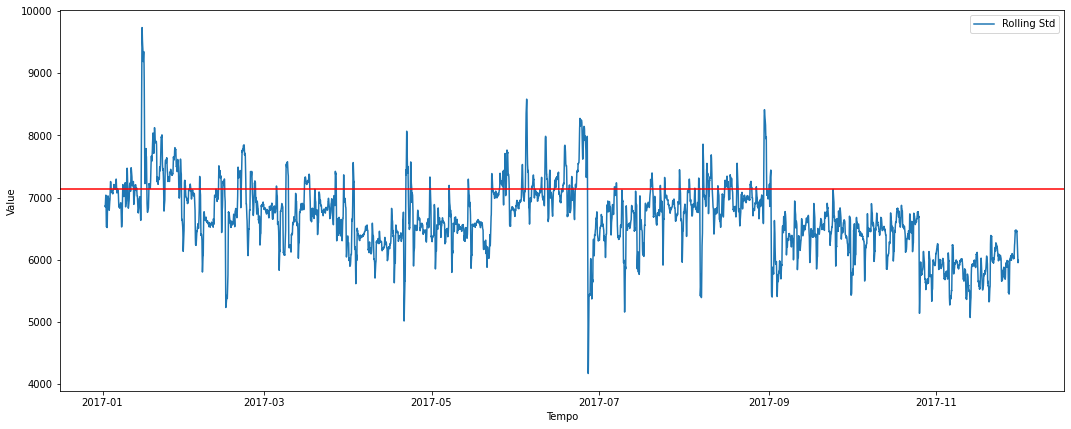

In [38]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value'].rolling(window=144).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std")
plt.axhline(data['Value'].std(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

"Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting."

In [39]:
# Philips Perron test (PP Test)

In [40]:
#Breusch Godfrey Test
# from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# test_result = acorr_breusch_godfrey(ts, model_fit)
# p_value = test_result[3]

# Trasformazioni

## Box-Cox

In [41]:
# Cerco il lambda ottimale
lambda_opt = boxcox_normmax(data['Value'])
print(lambda_opt)

# Applico Box-Cox con il lambda ottimale trovato
data['Value_BoxCox'] = boxcox(data['Value'], lmbda=lambda_opt)
print(data['Value_BoxCox'])

0.46800714402204047
Date
2017-01-01 00:00:00    280.250284
2017-01-01 00:10:00    263.209447
2017-01-01 00:20:00    260.331974
2017-01-01 00:30:00    256.508111
2017-01-01 00:40:00    252.645384
                          ...    
2017-11-30 23:10:00    269.509614
2017-11-30 23:20:00    266.470467
2017-11-30 23:30:00    263.519745
2017-11-30 23:40:00    260.842230
2017-11-30 23:50:00    258.028534
Name: Value_BoxCox, Length: 48096, dtype: float64


Testo ADF e KPSS

In [42]:
run_adf_test(data['Value_BoxCox'])

ADF Statistic: -33.370400406153365
p-value: 0.0
Critical Values:
   1%, -3.4304861264221036
Critical Values:
   5%, -2.8616001650288383
Critical Values:
   10%, -2.566802023864426
The time series is stationary in mean.


In [43]:
run_kpss_test(data['Value_BoxCox'])


KPSS Statistic: 4.171477
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Non cambia praticamente nulla, provo a procedere con una trasformazione logaritmica.

## Log

In [44]:
data['Value_Log'] = np.log(data['Value'])
print(data['Value_Log'])

Date
2017-01-01 00:00:00    10.435753
2017-01-01 00:10:00    10.302756
2017-01-01 00:20:00    10.279459
2017-01-01 00:30:00    10.248100
2017-01-01 00:40:00    10.215949
                         ...    
2017-11-30 23:10:00    10.352896
2017-11-30 23:20:00    10.328856
2017-11-30 23:30:00    10.305254
2017-11-30 23:40:00    10.283609
2017-11-30 23:50:00    10.260624
Name: Value_Log, Length: 48096, dtype: float64


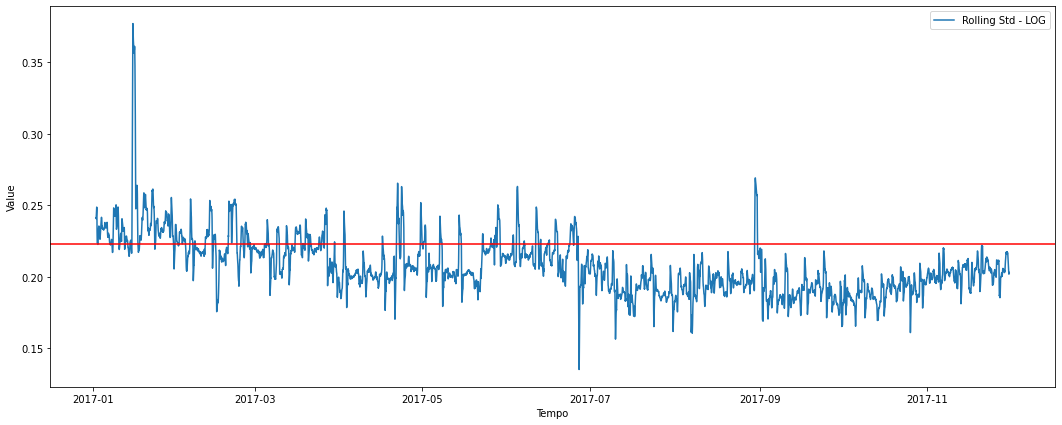

In [45]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value_Log'].rolling(window=144).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std - LOG")
plt.axhline(data['Value_Log'].std(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

Riduce la varianza della serie storica.

Testo ADF e KPSS

In [46]:
run_adf_test(data['Value_Log'])

ADF Statistic: -33.28763630998326
p-value: 0.0
Critical Values:
   1%, -3.4304861264221036
Critical Values:
   5%, -2.8616001650288383
Critical Values:
   10%, -2.566802023864426
The time series is stationary in mean.


In [47]:
run_kpss_test(data['Value_Log'])


KPSS Statistic: 4.191695
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Anche in questo caso non cambia praticamente nulla, dobbiamo procedere con una differenziazione (come suggerito anche dalla documentazione di statsmodels).

## Differenziazione

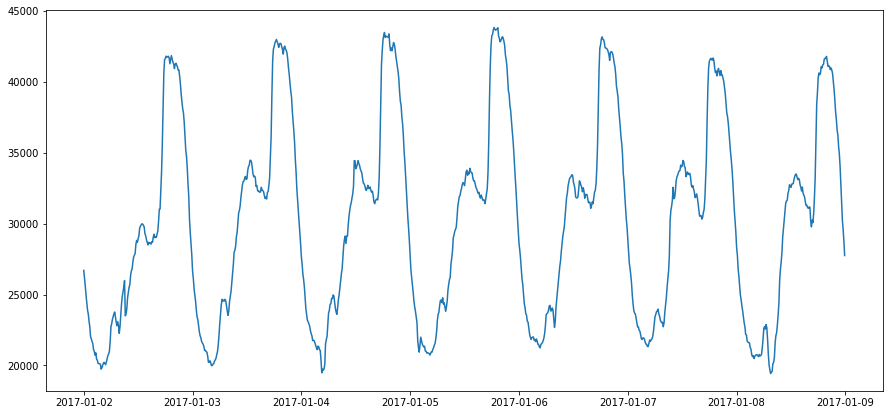

In [48]:
fig, ax = plt.subplots(1, 1, figsize =(15,7))
plt.plot(data[data['Num_WeekofYear'] == 1]['Value']) #plot della prima settimana di dati

Vedendo la prima settimana di dati si può vedere la presenza di una stagionalità giornaliera.

In [49]:
for i in range(1, data['Num_WeekofYear'].nunique()):
    fig, ax = plt.subplots(1, 1, figsize =(15,7))
    plt.plot(data[data['Num_WeekofYear'] == i]['Value'])

Output hidden; open in https://colab.research.google.com to view.

Procedo con la differenziazione giornaliera.

In [50]:
data_diff = data.copy()

In [51]:
data_diff['Value'] = data_diff['Value'].diff(144)
print(data_diff['Value']) #ci sono valori NA, quindi li devo droppare

Date
2017-01-01 00:00:00           NaN
2017-01-01 00:10:00           NaN
2017-01-01 00:20:00           NaN
2017-01-01 00:30:00           NaN
2017-01-01 00:40:00           NaN
                          ...    
2017-11-30 23:10:00    1347.69231
2017-11-30 23:20:00    1212.30769
2017-11-30 23:30:00    1286.15385
2017-11-30 23:40:00    1575.38462
2017-11-30 23:50:00    1600.00000
Name: Value, Length: 48096, dtype: float64


In [52]:
data_diff = data_diff.dropna()
print(data_diff['Value'])

Date
2017-01-02 00:00:00   -7351.89873
2017-01-02 00:10:00   -3645.56962
2017-01-02 00:20:00   -3505.82279
2017-01-02 00:30:00   -3256.70886
2017-01-02 00:40:00   -2898.22785
                          ...    
2017-11-30 23:10:00    1347.69231
2017-11-30 23:20:00    1212.30769
2017-11-30 23:30:00    1286.15385
2017-11-30 23:40:00    1575.38462
2017-11-30 23:50:00    1600.00000
Name: Value, Length: 47952, dtype: float64


Testo ADF e KPSS

In [53]:
run_adf_test(data_diff['Value'])

ADF Statistic: -19.459394832178386
p-value: 0.0
Critical Values:
   1%, -3.43048654140327
Critical Values:
   5%, -2.861600348437607
Critical Values:
   10%, -2.566802121487611
The time series is stationary in mean.


In [54]:
run_kpss_test(data_diff['Value'])


KPSS Statistic: 0.052548
p-value: 0.100000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Tramite la differenziazione giornaliera si riesce a rendere la serie storica stazionaria anche in varianza.

### ACF e PACF

ACF e PACF 

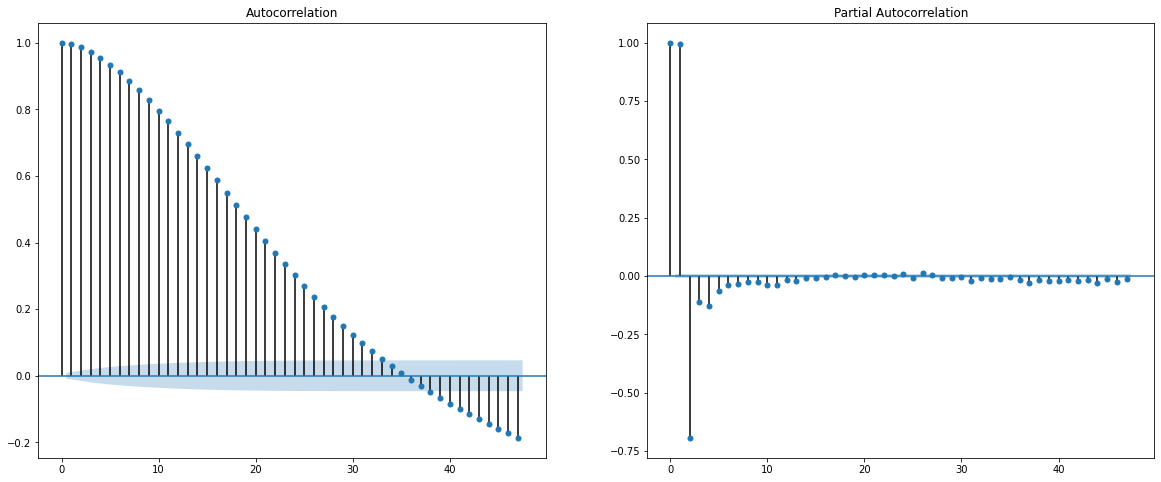

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data['Value'], ax = ax[0])
plot_pacf(data['Value'], ax = ax[1])

plt.show()

ACF rientra gradualmente verso 0, poi scende sotto lo 0: sembra oscillare. PACF esce fino al 15° ritardi circa.

ACF e PACF della serie storica differenziata.

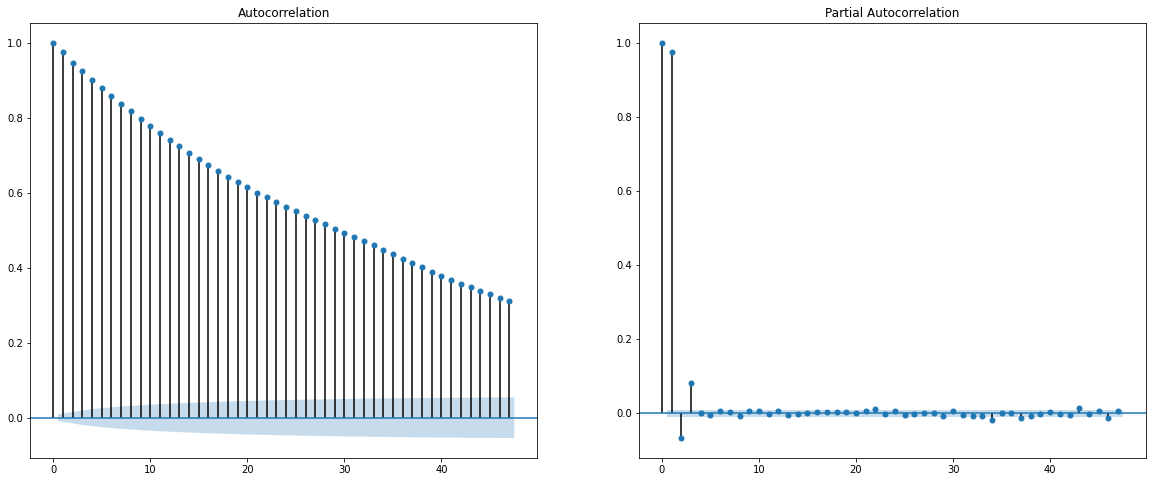

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data_diff['Value'], ax = ax[0])
plot_pacf(data_diff['Value'], ax = ax[1])

plt.show()

ACF sta rientando gradualmente verso 0. PACF ha i primi 3 ritardi che escono. 

## Divisione train-validation serie

In [57]:
# train_set_diff = data_diff.loc[ "2017-09-01 00:00:00": "2017-10-31 23:50:00"]
# validation_set_diff = data_diff.loc["2017-11-01 00:00:00" : ]

In [58]:
train = data.loc[ "2017-09-01 00:00:00": "2017-10-31 23:50:00"]
validation = data.loc["2017-11-01 00:00:00" : ] 

#### Salvataggio

In [ ]:
validation.to_csv('validation.csv', index=False)
from google.colab import files
files.download('validation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train.to_csv('train.csv', index=False)
from google.colab import files
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Machine Learning

## Novembre
train fino a ottobre, validation su novembre

In [59]:
train_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/train_tot.csv')
validation_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/validation_tot.csv')

In [60]:
train_tot = train_tot.set_index('Date')
validation_tot = validation_tot.set_index('Date')

In [ ]:
# train_tot

In [ ]:
# validation_tot

### Regressori Ramadan e notte

In [61]:
start_date = '2017-05-26 00:00:00'
end_date = '2017-06-24 23:59:00'

train_tot['ram'] = np.where((train_tot.index >= start_date) & (train_tot.index <= end_date), 1, 0)
validation_tot['ram'] = np.where((validation_tot.index >= start_date) & (validation_tot.index <= end_date), 1, 0)

In [62]:
train_tot['Night'] = np.where((train_tot.Hour >= 21) | (train_tot.Hour <= 5), 1, 0)
validation_tot['Night'] = np.where((validation_tot.Hour >= 21) | (validation_tot.Hour <= 5), 1, 0)

In [63]:
#defining input and target variable
X_train = train_tot.loc['2017-01-00 00:00:00' : '2017-10-31 23:50:00', ['Num_DayofYear', 'Hour', 'Minute', 
                                                                        'Month', "Num_DayofWeek", 
                                                                        'Num_WeekofYear', 'Quarter', 
                                                                        'ram', 'Night']]

y_train = train_tot.loc['2017-01-00 00:00:00' : '2017-10-31 23:50:00', ['Value']]

X_test = validation_tot.loc['2017-11-01 00:00:00' : '2017-11-30 23:50:00', ['Num_DayofYear', 'Hour', 'Minute', 
                                                                        'Month', "Num_DayofWeek", 
                                                                        'Num_WeekofYear', 'Quarter',
                                                                        'ram', 'Night']]

y_test = validation_tot.loc['2017-11-01 00:00:00' : '2017-11-30 23:50:00', ['Value']]

In [64]:
# X_train

In [65]:
# X_test

In [66]:
# y_test

### XGBoost

#### XGBoost1

In [67]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#XGBoost hyper-parameter tuning

def hyperParameterTuning(X_train, y_train):
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:linear']
    }

    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                               param_grid = param_grid,                        
                               scoring = 'mean_absolute_error', #MAE
                               #scoring = 'neg_mean_squared_error',  #MSE
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)
    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [68]:
# hyperParameterTuning(X_train, y_train) con questi parametri ci mette 1h e 20 e da come mae 1838

In [69]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error


xgb_model1 = XGBRegressor(booster='gbtree',
                          colsample_bytree = 0.7,
                          learning_rate = 0.1,
                          max_depth = 5,
                          min_child_weight = 3,
                          n_estimators = 100,
                          objective = 'reg:linear',
                          subsample = 0.5)
xgb_model1.fit(X_train,y_train)
validation_tot['xgb_hyp_params_prediction'] = xgb_model1.predict(X_test)
validation_tot['xgb_hyp_params_prediction']
# np.sqrt(mean_squared_error(y_test,validation_tot['xgb_hyp_params_prediction']))

mae_value = metrics.mean_absolute_error(validation_tot['xgb_hyp_params_prediction'], y_test)
print("MAE value is:", mae_value)

[07:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE value is: 1480.839568995949


#### XGBoost 2

In [70]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# # Define the range of hyperparameters to search over
# param_grid = {'booster': ['gbtree'],
#               'colsample_bytree': [0.7],
#               'learning_rate': [0.1],
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [3, 4, 5],
#               'n_estimators': [100, 200, 300],
#               'base_score': [0.5, 0.7, 0.9],
#               'early_stopping_rounds': [10, 20, 30],
#               'objective': ['reg:linear'],
#               'subsample': [0.5]}

# # Initialize the XGBRegressor model
# xgb_model = xgb.XGBRegressor()

# # Initialize the grid search
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Use the best hyperparameters to initialize a new XGBRegressor model
# best_xgb_model = xgb.XGBRegressor(**best_params)

# # Fit the best XGBRegressor model to the data
# best_xgb_model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_xgb_model.predict(X_test)

In [71]:
# best_params

In [72]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error


xgb_model2 = XGBRegressor(base_score= 0.5,
                          booster='gbtree', 
                          colsample_bytree = 0.7,   
                          n_estimators=300,
                          early_stopping_rounds= 10,
                          min_child_weight = 3,
                          objective='reg:linear',
                          max_depth=6,
                          learning_rate=0.1, 
                          subsample = 0.5,
                          random_state = 123)
xgb_model2.fit(X_train, y_train, verbose = 100)
validation_tot['xgb_hyp_params_prediction2'] = xgb_model2.predict(X_test)
validation_tot['xgb_hyp_params_prediction2']
# np.sqrt(mean_squared_error(y_test,validation_tot['xgb_hyp_params_prediction']))

mae_value2 = metrics.mean_absolute_error(validation_tot['xgb_hyp_params_prediction2'], y_test)
print("MAE value is:", mae_value2)

[07:13:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE value is: 1260.890386814815


### Plot Predizioni vs Validation Set

In [75]:
validation_tot.index = pd.to_datetime(validation_tot.index)

In [76]:
validation_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log,ram,Night,xgb_hyp_params_prediction,xgb_hyp_params_prediction2
Date,,,,,,,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892,0,1,26715.742188,27354.417969
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476,0,1,26414.816406,26995.517578
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186,0,1,26058.298828,26440.072266
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431,0,1,25585.142578,26109.027344
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107,0,1,25209.871094,25865.853516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896,0,1,30148.761719,29965.345703
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856,0,1,29547.201172,29658.402344
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254,0,1,28421.105469,28637.394531


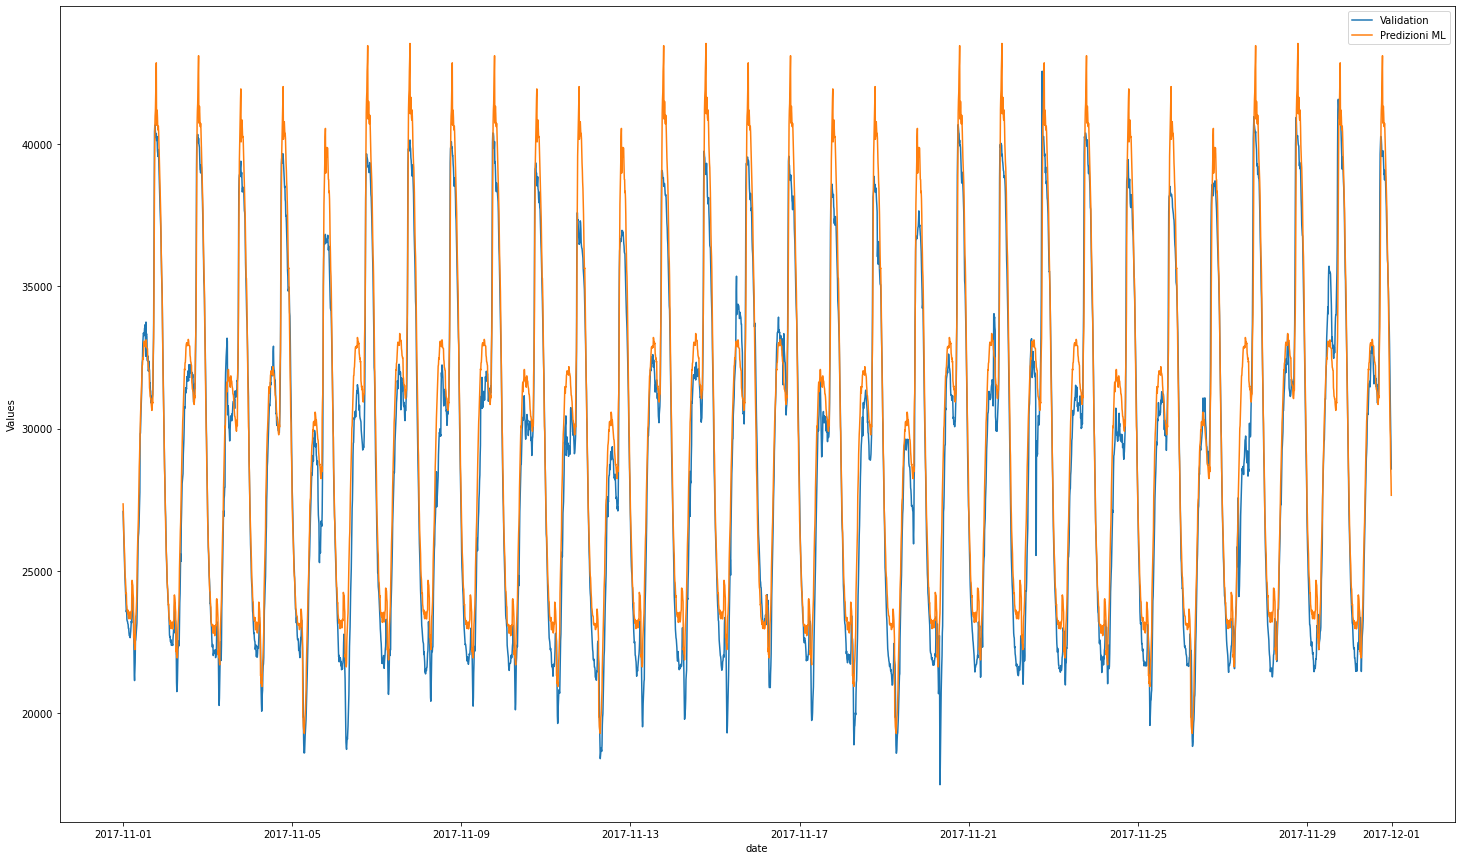

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(validation_tot.index, validation_tot.Value, label='Validation')
plt.plot(validation_tot.index, validation_tot.xgb_hyp_params_prediction2, label='Predizioni ML')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

### Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# import warnings
# warnings.filterwarnings("ignore")
# from sklearn import metrics
  
#  # create regressor object
# rf_regressor = RandomForestRegressor(n_estimators = 200, criterion = 'absolute_error', random_state = 123)
  
# # fit the regressor with x and y data
# rf_regressor.fit(X_train, y_train)

# #Predict the test data
# validation_tot['rf_prediction'] = rf_regressor.predict(X_test)
# # np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction']))

# mae_value = metrics.mean_absolute_error(validation_tot["rf_prediction"], y_test)
# print("MAE value is:", mae_value)

#### GridSearch

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# # Definizione della griglia di parametri
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [10, 30, 50],
#     'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 10, 20],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [123]
# }

# # Creazione del modello RandomForestRegressor
# rf1 = RandomForestRegressor()

# # Creazione di un oggetto di ricerca su griglia
# rf_grid = GridSearchCV(
#     estimator=rf1,
#     param_grid=param_grid,
#     scoring = "neg_mean_absolute_error",
#     n_jobs=-1,
#     cv=5
# )

# # Addestramento del modello sui dati
# rf_grid.fit(X_train, y_train)

# # Stampa dei parametri ottimali
# print("I parametri ottimali sono: ", rf_grid.best_params_)

# #Predict the test data
# validation_tot['rf_prediction_grid'] = rf_grid.predict(X_test)
# # np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid']))

# mae_value1 = metrics.mean_absolute_error(validation_tot["rf_prediction_grid"], y_test)
# print("MAE value is:", mae_value1)

Uso i parametri migliori

In [ ]:
rf_grid_best = RandomForestRegressor(
    n_estimators= 50,
    max_depth= 10,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features='auto',
    random_state=123
)

# Addestramento del modello con i dati
rf_grid_best.fit(X_train, y_train)

#Predict the test data
validation_tot['rf_prediction_grid_best'] = rf_grid_best.predict(X_test)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_value_best1 = metrics.mean_absolute_error(validation_tot["rf_prediction_grid_best"], y_test)
print("MAE value is:", mae_value_best1)

MAE value is: 1570.777232211729


#### Random Search

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# # Definizione della distribuzione casuale per i parametri
# param_dist = {
#     'n_estimators': sp_randint(50, 150),
#     'max_depth': sp_randint(10, 50),
#     'min_samples_split': sp_randint(2, 20),
#     'min_samples_leaf': sp_randint(1, 20),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [123]
# }

# # Creazione del modello RandomForestRegressor
# rf2 = RandomForestRegressor()

# # Creazione di un oggetto di ricerca casuale
# rf_random = RandomizedSearchCV(
#     estimator=rf2,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     cv=5,
#     random_state=123
# )

# # Addestramento del modello sui dati
# rf_random.fit(X_train, y_train)

# # Stampa dei parametri ottimali
# print("I parametri ottimali sono: ", rf_random.best_params_)

# #Predict the test data
# validation_tot['rf_prediction_random'] = rf_random.predict(X_test)
# # np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_random']))

# mae_value2 = metrics.mean_absolute_error(validation_tot["rf_prediction_random"], y_test)
# print("MAE value is:", mae_value2)

Uso i parametri migliori

In [ ]:
rf_random_best = RandomForestRegressor(
    n_estimators= 138,
    max_depth=13,
    min_samples_split=8,
    min_samples_leaf=8,
    max_features='auto',
    random_state=123
)

# Addestramento del modello con i dati
rf_random_best.fit(X_train, y_train)

#Predict the test data
validation_tot['rf_prediction_random_best'] = rf_random_best.predict(X_test)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_value_best2 = metrics.mean_absolute_error(validation_tot["rf_prediction_random_best"], y_test)
print("MAE value is:", mae_value_best2)

MAE value is: 1335.5728031278227


### Decision Tree Regressor

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# param_dist = {
#     'max_depth': sp_randint(1, 50),
#     'min_samples_split': sp_randint(2, 20),
#     'min_samples_leaf': sp_randint(1, 20),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [123]
# }

# dt = DecisionTreeRegressor()

# dt_random = RandomizedSearchCV(
#     estimator=dt,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     cv=5,
#     random_state=123
# )

# dt_random.fit(X_train, y_train)
# print("I parametri ottimali sono: ", dt_random.best_params_)

In [ ]:
dt_optimal = DecisionTreeRegressor(
    max_depth = 47,
    min_samples_split = 2,
    min_samples_leaf = 19,
    max_features = 'auto',
    random_state = 123
)

dt_optimal.fit(X_train, y_train)
y_pred = dt_optimal.predict(X_test)
from sklearn.metrics import mean_absolute_error

mae_dt = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae_dt)

MAE:  1538.5986372495086


### LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# param_grid = {'boosting_type': ['gbdt'],
# 'colsample_bytree': [0.7],
# 'learning_rate': [0.1],
# 'max_depth': [5, 6, 7],
# 'min_child_weight': [3, 4, 5],
# 'n_estimators': [100, 200, 300],
# 'objective': ['regression'],
# 'subsample': [0.5]}

# lgb_model = lgb.LGBMRegressor()

# grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_lgb_model = lgb.LGBMRegressor(**best_params)
# best_lgb_model.fit(X_train, y_train)

In [ ]:
# best_params

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

lightgbm_grid_best = lgb.LGBMRegressor(
    colsample_bytree=0.7, 
    max_depth=5, 
    min_child_weight=3,
    n_estimators=300, 
    objective='regression', 
    subsample=0.5, 
    random_state = 123    
)

# Addestramento del modello con i dati
lightgbm_grid_best.fit(X_train, y_train)

#Predict the test data
y_pred_lightgbm = lightgbm_grid_best.predict(X_test)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_lightgbm = metrics.mean_absolute_error(y_pred_lightgbm, y_test)
print("MAE value is:", mae_lightgbm)

MAE value is: 1334.0213879012258


### MALE SVR

In [ ]:
from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X_train1 = sc_X.fit_transform(X_train1)
# y_train1 = sc_y.fit_transform(y_train1.reshape(-1, 1))

# Standardizza i dati di addestramento e test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # Definisci la griglia di iperparametri
# param_grid_svr = {'C': [1, 10, 100, 1000],
#               'epsilon': [0.1, 0.2, 0.3],
#               'kernel': ['linear', 'poly', 'rbf']}

# # Crea un oggetto SVR
# svr_model = SVR()

# # Crea un oggetto GridSearchCV
# grid_search_svr = GridSearchCV(estimator=svr_model, 
#                            param_grid=param_grid_svr,
#                            cv=5, 
#                            scoring='neg_mean_absolute_error')

# # Esegui la grid search
# grid_search_svr.fit(X_train_scaled, y_train)

# # Stampa i risultati della grid search
# print("Migliori parametri: ", grid_search_svr.best_params_)
# print("Miglior punteggio di validazione: ", grid_search_svr.best_score_)

# # Fai le previsioni sul set di test
# y_pred_svr = grid_search_svr.predict(X_test_scaled)

# # Calcola l'errore medio assoluto
# mae_svr = mean_absolute_error(y_test, y_pred_svr)
# print("MAE sul set di test: ", mae_svr)

# # mae_value_prova= metrics.mean_absolute_error(validation_tot["rf_prediction_random_best"], y_test)
# # print("MAE value is:", mae_value_prova)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


svr_model = SVR(C= 1000,                       # 1 10 100 1000
                epsilon= 0.5,                # 0.1, 0.2, 0.3
                                             #  gamma= , 
                kernel='rbf')                #'linear', 'poly', 'rbf'

# Fit the SVR model to the training data
svr_model.fit(X_train_scaled, y_train)

# Use the SVR model to make predictions on the test data
y_pred_svr = svr_model.predict(X_test_scaled)

# Calcola l'errore medio assoluto
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print("MAE sul set di test: ", mae_svr)

MAE sul set di test:  1991.0736383479089


### MALE Extra Trees Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np

# # Define the range of hyperparameters to search over
# param_grid = {'n_estimators': [100, 200, 300],
#               'max_depth': [5, 6, 7],
#               'min_samples_split': [2, 3, 4],
#               'min_samples_leaf': [1, 2, 3],
#               'max_features': ['auto', 'sqrt', 'log2']}

# # Initialize the Extra Trees Regressor
# etr = ExtraTreesRegressor()

# # Initialize the grid search
# grid_search = GridSearchCV(etr, param_grid, cv=5, scoring='neg_mean_absolute_error')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_

# # Use the best hyperparameters to initialize a new Extra Trees Regressor
# best_etr = ExtraTreesRegressor(**best_params)

# # Fit the best Extra Trees Regressor to the data
# best_etr.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_etr.predict(X_test)

# # Calculate the mean absolute error
# mae = metrics.mean_absolute_error(y_pred, y_test)
# print("MAE: ", mae)

In [ ]:
# best_params

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

extra_best = ExtraTreesRegressor(
    max_depth = 7,
    max_features = 'auto',
    min_samples_leaf = 2,
    min_samples_split = 3,
    n_estimators = 100, 
    random_state = 123
)

# Addestramento del modello con i dati
extra_best.fit(X_train, y_train)

#Predict the test data
y_pred_extra = extra_best.predict(X_test)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_extra = metrics.mean_absolute_error(y_pred_extra, y_test)
print("MAE value is:", mae_extra)

MAE value is: 3660.220912906821


## Dicembre
train fino a novembre, validation su dicembre



In [ ]:
train_dic_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/train_dic_tot.csv')
validation_dic_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/validation_dic_tot.csv')

In [ ]:
# train_dic_tot

In [ ]:
# validation_dic_tot

In [ ]:
train_dic_tot = train_dic_tot.set_index('Date')
validation_dic_tot = validation_dic_tot.set_index('Date')

### Regressori Ramadan e notte

In [ ]:
start_date = '2017-05-26 00:00:00'
end_date = '2017-06-24 23:59:00'

train_dic_tot['ram'] = np.where((train_dic_tot.index >= start_date) & (train_dic_tot.index <= end_date), 1, 0)
validation_dic_tot['ram'] = np.where((validation_dic_tot.index >= start_date) & (validation_dic_tot.index <= end_date), 1, 0)

In [ ]:
train_dic_tot['Night'] = np.where((train_dic_tot.Hour >= 21) | (train_dic_tot.Hour <= 5), 1, 0)
validation_dic_tot['Night'] = np.where((validation_dic_tot.Hour >= 21) | (validation_dic_tot.Hour <= 5), 1, 0)

In [ ]:
#defining input and target variable
X_train_dic = train_dic_tot.loc['2017-01-00 00:00:00' : '2017-11-30 23:50:00', ['Num_DayofYear', 'Hour', 'Minute', 
                                                                        'Month', "Num_DayofWeek", 
                                                                        'Num_WeekofYear', 'Quarter', 
                                                                        'ram', 'Night']]

y_train_dic = train_dic_tot.loc['2017-01-00 00:00:00' : '2017-11-30 23:50:00', ['Value']]

X_test_dic = validation_dic_tot.loc['2017-12-01 00:00:00' : '2017-12-30 23:50:00', ['Num_DayofYear', 'Hour', 'Minute', 
                                                                        'Month', "Num_DayofWeek", 
                                                                        'Num_WeekofYear', 'Quarter',
                                                                        'ram', 'Night']]

y_test_dic = validation_dic_tot.loc['2017-12-01 00:00:00' : '2017-12-30 23:50:00', ['Value']]

### XGBoost

#### XGBoost 1

In [ ]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#XGBoost hyper-parameter tuning

def hyperParameterTuning(X_train, y_train):
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:linear']
    }

    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                               param_grid = param_grid,                        
                               scoring = 'mean_absolute_error', #MAE
                               #scoring = 'neg_mean_squared_error',  #MSE
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)
    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [ ]:
# hyperParameterTuning(X_train, y_train) 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error


xgb_model_dic1 = XGBRegressor(colsample_bytree = 0.7,
        learning_rate = 0.1,
        max_depth = 5,
        min_child_weight = 3,
        n_estimators = 100,
        objective = 'reg:linear',
        subsample = 0.5)
xgb_model_dic1.fit(X_train_dic, y_train_dic)
validation_dic_tot['xgb_hyp_params_prediction'] = xgb_model_dic1.predict(X_test_dic)
validation_dic_tot['xgb_hyp_params_prediction']
# np.sqrt(mean_squared_error(y_train_dic,validation_dic_tot['xgb_hyp_params_prediction']))

mae_value = metrics.mean_absolute_error(validation_dic_tot['xgb_hyp_params_prediction'], y_test_dic)
print("MAE value is:", mae_value)

[21:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE value is: 875.4274044986979


#### XGBoost 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error


xgb_model_dic2 = XGBRegressor(base_score= 0.5,
                          booster='gbtree', 
                          colsample_bytree = 0.7,   
                          n_estimators=300,
                          early_stopping_rounds= 10,
                          min_child_weight = 3,
                          objective='reg:linear',
                          max_depth=6,
                          learning_rate=0.1, 
                          subsample = 0.5,
                          random_state = 123)
xgb_model_dic2.fit(X_train_dic, y_train_dic, verbose = 100)

validation_dic_tot['xgb_hyp_params_prediction2'] = xgb_model_dic2.predict(X_test_dic)
predizioni_df = xgb_model_dic2.predict(X_test_dic)

validation_dic_tot['xgb_hyp_params_prediction2']
# np.sqrt(mean_squared_error(y_test_dic, validation_dic_tot['xgb_hyp_params_prediction2']))

mae_value_dic2 = metrics.mean_absolute_error(validation_dic_tot['xgb_hyp_params_prediction2'], y_test_dic)
print("MAE value is:", mae_value_dic2)

[21:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE value is: 757.8245700209781


### Random Forest

#### GridSearch

In [ ]:
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# import warnings
# warnings.filterwarnings("ignore")
# from sklearn import metrics
# from sklearn.metrics import mean_absolute_error

# # Definizione della griglia di parametri
# param_grid_dic = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [10, 30, 50],
#     'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 10, 20],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [123]
# }

# # Creazione del modello RandomForestRegressor
# rf1_dic = RandomForestRegressor()

# # Creazione di un oggetto di ricerca su griglia
# rf_grid_dic = GridSearchCV(
#     estimator=rf1_dic,
#     param_grid=param_grid_dic,
#     scoring = "neg_mean_absolute_error",
#     n_jobs=-1,
#     cv=5
# )

# # Addestramento del modello sui dati
# rf_grid_dic.fit(X_train_dic, y_train_dic)

# # Stampa dei parametri ottimali
# print("I parametri ottimali sono: ", rf_grid_dic.best_params_)

# #Predict the test data
# validation_dic_tot['rf_prediction_grid_dic'] = rf_grid_dic.predict(X_test_dic)
# # np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_dic']))

# mae_value1_dic = metrics.mean_absolute_error(validation_dic_tot["rf_prediction_grid_dic"], y_test_dic)
# print("MAE value is:", mae_value1_dic)

Uso i parametri migliori

In [ ]:
rf_grid_best_dic = RandomForestRegressor(
    n_estimators= 50,
    max_depth= 10,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features='auto',
    random_state=123
)

# Addestramento del modello con i dati
rf_grid_best_dic.fit(X_train_dic, y_train_dic)

#Predict the test data
validation_dic_tot['rf_prediction_grid_best_dic'] = rf_grid_best_dic.predict(X_test_dic)

mae_value_best_dic1 = metrics.mean_absolute_error(validation_dic_tot["rf_prediction_grid_best_dic"], y_test_dic)
print("MAE value is:", mae_value_best_dic1)

MAE value is: 792.2768940177847


#### Random Search

In [ ]:
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint
# import warnings
# warnings.filterwarnings("ignore")
# from sklearn import metrics
# from sklearn.metrics import mean_absolute_error

# # Definizione della distribuzione casuale per i parametri
# param_dist_dic = {
#     'n_estimators': sp_randint(50, 150),
#     'max_depth': sp_randint(10, 50),
#     'min_samples_split': sp_randint(2, 20),
#     'min_samples_leaf': sp_randint(1, 20),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [123]
# }

# # Creazione del modello RandomForestRegressor
# rf2_dic = RandomForestRegressor()

# # Creazione di un oggetto di ricerca casuale
# rf_random_dic = RandomizedSearchCV(
#     estimator=rf2_dic,
#     param_distributions=param_dist_dic,
#     n_iter=100,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     cv=5,
#     random_state=123
# )

# # Addestramento del modello sui dati
# rf_random_dic.fit(X_train_dic, y_train_dic)

# # Stampa dei parametri ottimali
# print("I parametri ottimali sono: ", rf_random_dic.best_params_)

# #Predict the test data
# validation_dic_tot['rf_prediction_random_dic'] = rf_random_dic.predict(X_test_dic)
# # np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_random_dic']))

# mae_value2_dic = metrics.mean_absolute_error(validation_dic_tot["rf_prediction_random_dic"], y_test_dic)
# print("MAE value is:", mae_value2_dic)

Uso i parametri migliori

In [ ]:
rf_random_best_dic = RandomForestRegressor(
    n_estimators= 138,
    max_depth=13,
    min_samples_split=8,
    min_samples_leaf=8,
    max_features='auto',
    random_state=123
)

# Addestramento del modello con i dati
rf_random_best_dic.fit(X_train_dic, y_train_dic)

#Predict the test data
validation_dic_tot['rf_prediction_random_best_dic'] = rf_random_best_dic.predict(X_test_dic)

mae_value_best_dic2 = metrics.mean_absolute_error(validation_dic_tot["rf_prediction_random_best_dic"], y_test_dic)
print("MAE value is:", mae_value_best_dic2)

MAE value is: 751.974760330244


### Decision Tree Regressor

In [ ]:
dt_optimal_dic = DecisionTreeRegressor(
    max_depth = 47,
    min_samples_split = 2,
    min_samples_leaf = 19,
    max_features = 'auto',
    random_state = 123
)

dt_optimal_dic.fit(X_train_dic, y_train_dic)
y_pred_dic = dt_optimal_dic.predict(X_test_dic)

from sklearn.metrics import mean_absolute_error

mae_dt_dic = mean_absolute_error(y_test_dic, y_pred_dic)
print("MAE: ", mae_dt_dic)

MAE:  866.2586641655406


### Light GBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

lightgbm_grid_best_dic = lgb.LGBMRegressor(
    colsample_bytree=0.7, 
    max_depth=5, 
    min_child_weight=3,
    n_estimators=300, 
    objective='regression', 
    subsample=0.5, 
    random_state = 123    
)

# Addestramento del modello con i dati
lightgbm_grid_best_dic.fit(X_train_dic, y_train_dic)

#Predict the test data
y_pred_lightgbm_dic = lightgbm_grid_best_dic.predict(X_test_dic)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_lightgbm_dic = metrics.mean_absolute_error(y_pred_lightgbm_dic, y_test_dic)
print("MAE value is:", mae_lightgbm_dic)

MAE value is: 774.1117549963625


### MALE SVR

In [ ]:
from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X_train1 = sc_X.fit_transform(X_train1)
# y_train1 = sc_y.fit_transform(y_train1.reshape(-1, 1))

# Standardizza i dati di addestramento e test
scaler = StandardScaler()
X_train_scaled_dic = scaler.fit_transform(X_train_dic)
X_test_scaled_dic = scaler.transform(X_test_dic)

In [ ]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error

# # Definisci la griglia di iperparametri
# param_grid_svr = {'C': [1, 10, 100, 1000],
#               'epsilon': [0.1, 0.2, 0.3],
#               'kernel': ['linear', 'poly', 'rbf']}

# # Crea un oggetto SVR
# svr_model = SVR()

# # Crea un oggetto GridSearchCV
# grid_search_svr = GridSearchCV(estimator=svr_model, 
#                            param_grid=param_grid_svr,
#                            cv=5, 
#                            scoring='neg_mean_absolute_error')

# # Esegui la grid search
# grid_search_svr.fit(X_train_scaled, y_train)

# # Stampa i risultati della grid search
# print("Migliori parametri: ", grid_search_svr.best_params_)
# print("Miglior punteggio di validazione: ", grid_search_svr.best_score_)

# # Fai le previsioni sul set di test
# y_pred_svr = grid_search_svr.predict(X_test_scaled)

# # Calcola l'errore medio assoluto
# mae_svr = mean_absolute_error(y_test, y_pred_svr)
# print("MAE sul set di test: ", mae_svr)

# # mae_value_prova= metrics.mean_absolute_error(validation_tot["rf_prediction_random_best"], y_test)
# # print("MAE value is:", mae_value_prova)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


svr_model_dic = SVR(C= 1000,                       # 1 10 100 1000
                epsilon= 0.5,                # 0.1, 0.2, 0.3
                                             #  gamma= , 
                kernel='rbf')                #'linear', 'poly', 'rbf'

# Fit the SVR model to the training data
svr_model_dic.fit(X_train_scaled_dic, y_train_dic)

# Use the SVR model to make predictions on the test data
y_pred_svr_dic = svr_model_dic.predict(X_test_scaled_dic)

# Calcola l'errore medio assoluto
mae_svr_dic = mean_absolute_error(y_test_dic, y_pred_svr_dic)
print("MAE sul set di test: ", mae_svr_dic)

MAE sul set di test:  3200.3754208928544


### MALE Extra Trees Regressor

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import ExtraTreesRegressor
# import numpy as np

# # Define the range of hyperparameters to search over
# param_grid_dic = {'n_estimators': [100, 200, 300],
#               'max_depth': [5, 6, 7],
#               'min_samples_split': [2, 3, 4],
#               'min_samples_leaf': [1, 2, 3],
#               'max_features': ['auto', 'sqrt', 'log2']}

# # Initialize the Extra Trees Regressor
# etr_dic = ExtraTreesRegressor()

# # Initialize the grid search
# grid_search_dic = GridSearchCV(etr_dic, param_grid_dic, cv=5, scoring='neg_mean_absolute_error')

# # Fit the grid search to the data
# grid_search_dic.fit(X_train_dic, y_train_dic)

# # Get the best hyperparameters
# best_params_dic = grid_search_dic.best_params_

# # Use the best hyperparameters to initialize a new Extra Trees Regressor
# best_etr_dic = ExtraTreesRegressor(**best_params_dic)

# # Fit the best Extra Trees Regressor to the data
# best_etr_dic.fit(X_train_dic, y_train_dic)

# # Make predictions on the test data
# y_pred_extra_dic = best_etr_dic.predict(X_test_dic)

# # Calculate the mean absolute error
# mae_extra_dic = metrics.mean_absolute_error(y_pred_extra_dic, y_test_dic)
# print("MAE: ", mae_extra_dic)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

extra_best_dic = ExtraTreesRegressor(
    max_depth = 7,
    max_features = 'auto',
    min_samples_leaf = 2,
    min_samples_split = 3,
    n_estimators = 100, 
    random_state = 123
)

# Addestramento del modello con i dati
extra_best_dic.fit(X_train_dic, y_train_dic)

#Predict the test data
y_pred_extra_dic = extra_best_dic.predict(X_test_dic)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_extra_dic = metrics.mean_absolute_error(y_pred_extra_dic, y_test_dic)
print("MAE value is:", mae_extra_dic)

MAE value is: 1340.671991977385


# CREAZIONE DATASET PER PREDIZIONI

In [ ]:
predizioni_df = pd.DataFrame(predizioni_df)

In [ ]:
predizioni_df

,0
0,26620.933594
1,26176.349609
2,25701.673828
3,25233.123047
4,24978.218750
...,...
4315,31448.871094
4316,30715.480469
4317,29897.845703
4318,29429.875000


In [ ]:
start_date = '2017-12-01 00:00:00'
end_date = '2017-12-30 23:59:59'

date_range = pd.date_range(start=start_date, end=end_date, freq='10min')

predizioni_df = predizioni_df.copy()
predizioni_df['date'] = date_range
predizioni_df = predizioni_df.set_index('date')

In [ ]:
predizioni_df

,0
date,
2017-12-01 00:00:00,26620.933594
2017-12-01 00:10:00,26176.349609
2017-12-01 00:20:00,25701.673828
2017-12-01 00:30:00,25233.123047
2017-12-01 00:40:00,24978.218750
...,...
2017-12-30 23:10:00,31448.871094
2017-12-30 23:20:00,30715.480469
2017-12-30 23:30:00,29897.845703


In [ ]:
# predizioni_df = predizioni_df.drop(columns = ["Num_DayofYear", "Hour", "Minute"])

In [ ]:
predizioni_df = predizioni_df.rename(columns={0: 'ML'})

In [ ]:
predizioni_df

,ML
date,
2017-12-01 00:00:00,26620.933594
2017-12-01 00:10:00,26176.349609
2017-12-01 00:20:00,25701.673828
2017-12-01 00:30:00,25233.123047
2017-12-01 00:40:00,24978.218750
...,...
2017-12-30 23:10:00,31448.871094
2017-12-30 23:20:00,30715.480469
2017-12-30 23:30:00,29897.845703


In [ ]:
# mae_value_best_dic2 = metrics.mean_absolute_error(predizioni_df["ML"], y_test_dic)
# print("MAE value is:", mae_value_best_dic2)

MAE value is: 757.8245700209781


In [ ]:
predizioni_df.to_csv('predizioni_df_ML.csv', index=True)
from google.colab import files
files.download('predizioni_df_ML.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# UNIONE DATAFRAME PREDIZIONE FINALE

In [110]:
path = "/content/drive/MyDrive/Progetto SDMTSA/predizioni_df_ARIMA.csv"
predizioni_df_ARIMA = pd.read_csv(path)

In [111]:
path = "/content/drive/MyDrive/Progetto SDMTSA/predizioni_df_UCM.csv"
predizioni_df_UCM = pd.read_csv(path)

In [112]:
path = "/content/drive/MyDrive/Progetto SDMTSA/predizioni_df_ML.csv"
predizioni_df_ML = pd.read_csv(path)

In [113]:
predizioni_df_ARIMA = predizioni_df_ARIMA.rename(columns = {'date': 'data'})

In [114]:
predizioni_df_ARIMA

,data,ARIMA
0,2017-12-01 00:00:00,26821.989011
1,2017-12-01 00:10:00,25913.427909
2,2017-12-01 00:20:00,25936.189098
3,2017-12-01 00:30:00,25086.938807
4,2017-12-01 00:40:00,24981.420017
...,...,...
4315,2017-12-30 23:10:00,31096.193520
4316,2017-12-30 23:20:00,28474.893115
4317,2017-12-30 23:30:00,29643.722143
4318,2017-12-30 23:40:00,27170.826912


In [115]:
predizioni_totale = pd.concat([predizioni_df_ARIMA, predizioni_df_UCM, predizioni_df_ML], axis=1)

In [116]:
predizioni_totale

,data,ARIMA,date,UCM,date,ML
0,2017-12-01 00:00:00,26821.989011,2017-12-01 00:00:00,26715.169671,2017-12-01 00:00:00,26620.934
1,2017-12-01 00:10:00,25913.427909,2017-12-01 00:10:00,25806.608569,2017-12-01 00:10:00,26176.350
2,2017-12-01 00:20:00,25936.189098,2017-12-01 00:20:00,26055.054538,2017-12-01 00:20:00,25701.674
3,2017-12-01 00:30:00,25086.938807,2017-12-01 00:30:00,25205.804247,2017-12-01 00:30:00,25233.123
4,2017-12-01 00:40:00,24981.420017,2017-12-01 00:40:00,25071.042056,2017-12-01 00:40:00,24978.219
...,...,...,...,...,...,...
4315,2017-12-30 23:10:00,31096.193520,2017-12-30 23:10:00,32947.987507,2017-12-30 23:10:00,31448.871
4316,2017-12-30 23:20:00,28474.893115,2017-12-30 23:20:00,30141.914074,2017-12-30 23:20:00,30715.480
4317,2017-12-30 23:30:00,29643.722143,2017-12-30 23:30:00,31310.743102,2017-12-30 23:30:00,29897.846
4318,2017-12-30 23:40:00,27170.826912,2017-12-30 23:40:00,28960.224412,2017-12-30 23:40:00,29429.875


In [117]:
predizioni_totale = predizioni_totale.drop(columns=['date'])

In [118]:
predizioni_totale

,data,ARIMA,UCM,ML
0,2017-12-01 00:00:00,26821.989011,26715.169671,26620.934
1,2017-12-01 00:10:00,25913.427909,25806.608569,26176.350
2,2017-12-01 00:20:00,25936.189098,26055.054538,25701.674
3,2017-12-01 00:30:00,25086.938807,25205.804247,25233.123
4,2017-12-01 00:40:00,24981.420017,25071.042056,24978.219
...,...,...,...,...
4315,2017-12-30 23:10:00,31096.193520,32947.987507,31448.871
4316,2017-12-30 23:20:00,28474.893115,30141.914074,30715.480
4317,2017-12-30 23:30:00,29643.722143,31310.743102,29897.846
4318,2017-12-30 23:40:00,27170.826912,28960.224412,29429.875


In [119]:
predizioni_totale = predizioni_totale.rename(columns = {'data': 'date'})

In [120]:
predizioni_totale

,date,ARIMA,UCM,ML
0,2017-12-01 00:00:00,26821.989011,26715.169671,26620.934
1,2017-12-01 00:10:00,25913.427909,25806.608569,26176.350
2,2017-12-01 00:20:00,25936.189098,26055.054538,25701.674
3,2017-12-01 00:30:00,25086.938807,25205.804247,25233.123
4,2017-12-01 00:40:00,24981.420017,25071.042056,24978.219
...,...,...,...,...
4315,2017-12-30 23:10:00,31096.193520,32947.987507,31448.871
4316,2017-12-30 23:20:00,28474.893115,30141.914074,30715.480
4317,2017-12-30 23:30:00,29643.722143,31310.743102,29897.846
4318,2017-12-30 23:40:00,27170.826912,28960.224412,29429.875


In [106]:
# predizioni_totale.to_csv('predizioni_totale.csv', index=True)
# from google.colab import files
# files.download('predizioni_totale.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## plot predizioni a confronto

In [121]:
predizioni_totale.date = pd.to_datetime(predizioni_totale.date)

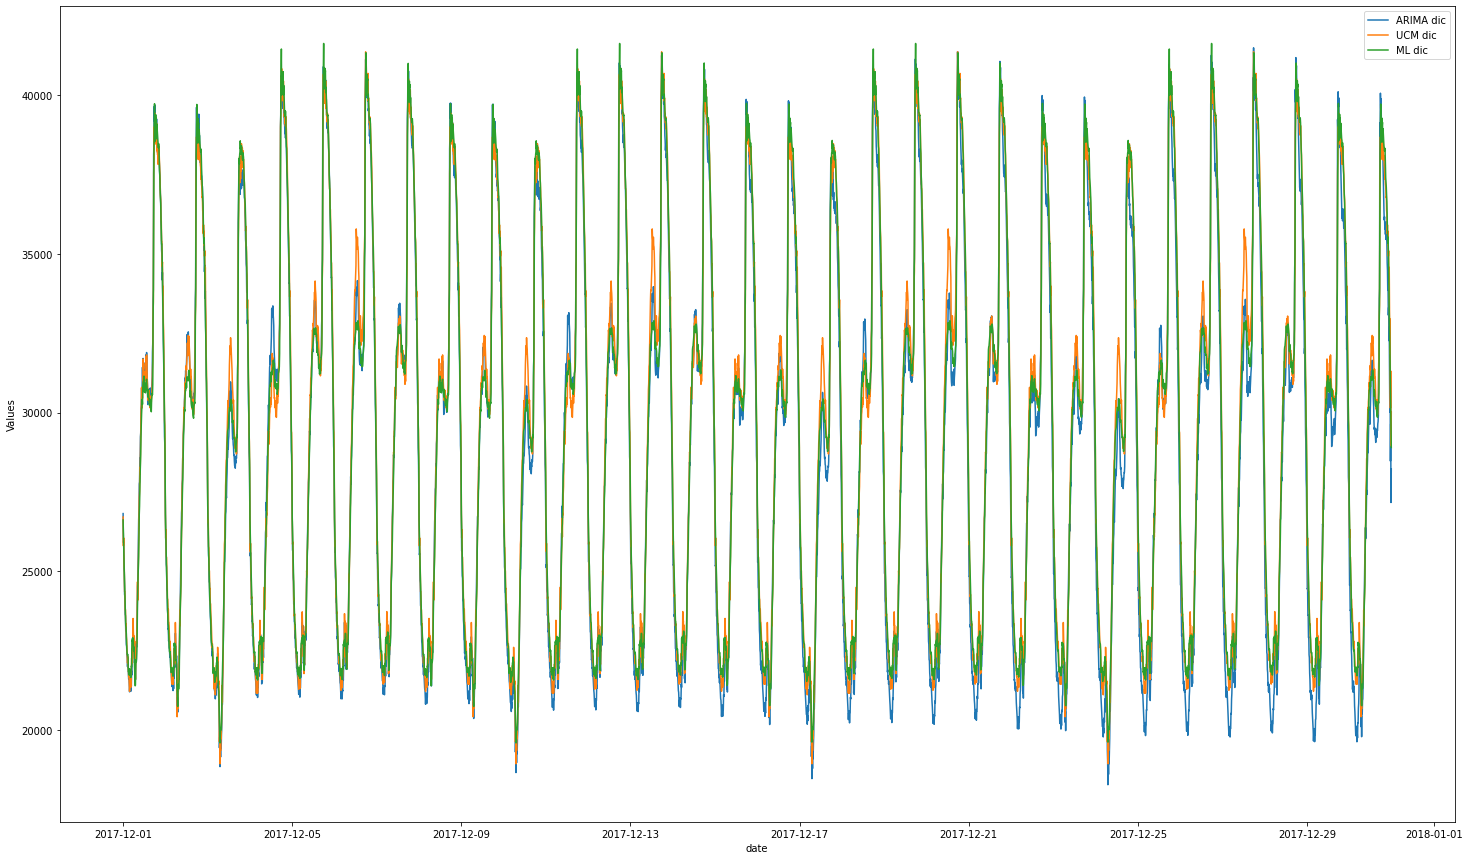

In [122]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(predizioni_totale.date, predizioni_totale.ARIMA, label='ARIMA dic')
plt.plot(predizioni_totale.date, predizioni_totale.UCM, label='UCM dic')
plt.plot(predizioni_totale.date, predizioni_totale.ML, label='ML dic')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()